# Notebook 3 - Orthorectify GOES data using goes-ortho

This tests Steven's orthorectification code from goes-ortho. Copied from `goes-ortho/docs/examples
/goes-orthorectify.ipynb` on github.

The input is raw GOES ABI netcdf files and the output is corrected netcdfs. These can then be converted to zarr and processed into RGB composites as I have done with previous code (see `/processing/00_goes_rad_corrections.ipynb`)

In [1]:
import goes_ortho
import orthorectify_modded
import xarray as xr
import matplotlib.pyplot as plt

We will use the goes_ortho.ortho() function to orthorectify and clip a GOES ABI image for an area within lat/lon bounds we'll specify.

First, provide a filepath to the GOES ABI image we want to orthorectify:

In [16]:
path = '/storage/cdalden/goes/washington/goes17/2022/8/4/ABI-L1b-RadC/20/C13/'
goes_image_path = path + "OR_ABI-L1b-RadC-M6C13_G17_s20222162056177_e20222162058561_c20222162059001.nc"

We can specify a list of the variables in the dataset that we want to include in the orthorectified dataset:

In [3]:
data_vars = ["Rad"]

And then we need to provide a new filepath and filename for where to save the final orthorectified dataset:

In [4]:
new_goes_filename = path + "OR_ABI-L1b-RadC-M6C13_G16_s20222161601175_e20222161603559_c20222161604015_ortho.nc"

Finally, specify the lat/lon bounds for the area we want to orthorectify, like (min lon, min lat, max lon, max lat):

In [5]:
bounds = (-124, 48, -121, 49)

Run the function!

Note: goes_ortho.ortho does not exist as described in the example notebook, using goes_ortho.orthorectify.ortho instead

In [6]:
api_key = "41d14aae7e761c0de3e8f99aa4fd24d9"

orthorectify_modded.ortho(
    goes_image_path,
    data_vars,
    bounds,
    api_key,
    new_goes_filename,
    dem_filepath=None,
    demtype="SRTMGL3",
    keep_dem=False,
)

/home/cdalden/miniforge3/envs/goesenv/bin/gdalwarp -r cubic -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER -tr 30 30 -t_srs '+proj=lonlat +ellps=GRS80' temp_SRTMGL3_DEM.tif temp_SRTMGL3_DEM_proj.tif
/home/cdalden/miniforge3/envs/goesenv/bin/gdalwarp -r cubic -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER -tr 30 30 -t_srs '+proj=lonlat +ellps=GRS80' temp_SRTMGL3_DEM.tif temp_SRTMGL3_DEM_proj.tif
Creating output file that is 1P x 1L.
Using internal nodata values (e.g. 0) for image temp_SRTMGL3_DEM.tif.
Copying nodata values from source temp_SRTMGL3_DEM.tif to destination temp_SRTMGL3_DEM_proj.tif.
Processing temp_SRTMGL3_DEM.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Child returned 0
/home/cdalden/miniforge3/envs/goesenv/lib/python3.13/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'cfgrib' loading failed:
expected string or bytes-like object, got 'NoneType'
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)


In [15]:
new_goes_filename

'./OR_ABI-L1b-RadC-M6C13_G16_s20222161601175_e20222161603559_c20222161604015_ortho.nc'

Open the new file we created, and plot it:

In [13]:
ds_ortho = xr.open_dataset(new_goes_filename)
ds = xr.open_dataset(goes_image_path)
ds_ortho

<xarray.Dataset> Size: 225MB
Dimensions:           (latitude: 1200, longitude: 3600)
Coordinates:
  * longitude         (longitude) float64 29kB -124.0 -124.0 ... -121.0 -121.0
  * latitude          (latitude) float64 10kB 49.0 49.0 49.0 ... 48.0 48.0 48.0
    dem_px_angle_x    (latitude, longitude) float64 35MB ...
    dem_px_angle_y    (latitude, longitude) float64 35MB ...
Data variables:
    elevation         (latitude, longitude) float32 17MB ...
    Rad               (latitude, longitude) float32 17MB ...
    tb                (latitude, longitude) float32 17MB ...
    abi_fixed_grid_x  (latitude, longitude) float64 35MB ...
    abi_fixed_grid_y  (latitude, longitude) float64 35MB ...
    zone_labels       (latitude, longitude) int64 35MB ...
Attributes: (12/21)
    longitude_of_projection_origin:       -137.0
    semi_major_axis:                      6378137.0
    semi_minor_axis:                      6356752.31414
    satellite_height:                     42164160.0
    grs80_eccentricity:                   0.0818191910435
    longitude_of_projection_origin_info:  longitude of geostationary satellit...
    ...                                   ...
    dem_ifov_info:                        instantaneous field of view (angula...
    dem_px_angle_x_info:                  DEM grid cell X coordinate (east/we...
    dem_px_angle_y_info:                  DEM grid cell Y coordinate (north/s...
    longitude_info:                       longitude from DEM file
    latitude_info:                        latitude from DEM file
    elevation_info:                       elevation from DEM file

ValueError: operands could not be broadcast together with shapes (63,121) (1200,3600) 

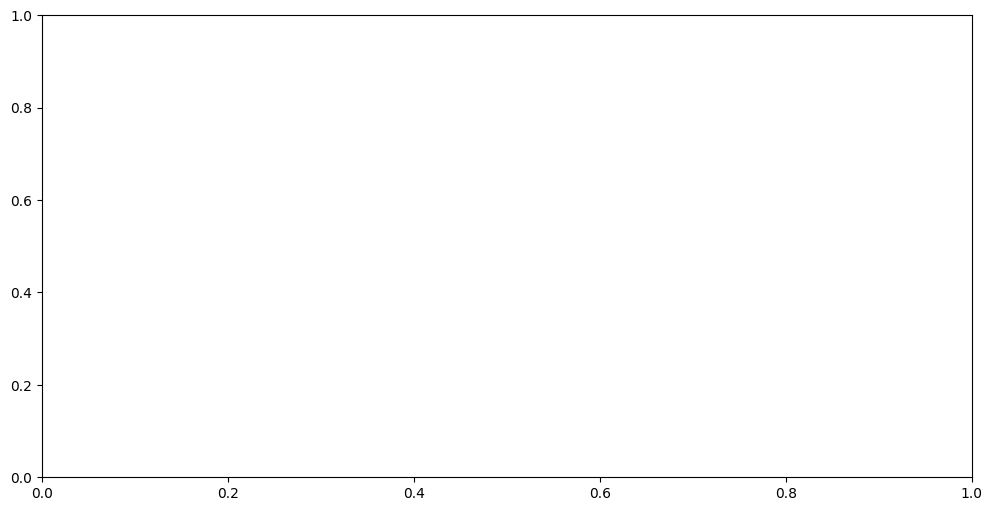

In [11]:
# subtract ortho from original to see if they match
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(ds.Rad.values - ds_ortho.Rad.values, cmap="gray")

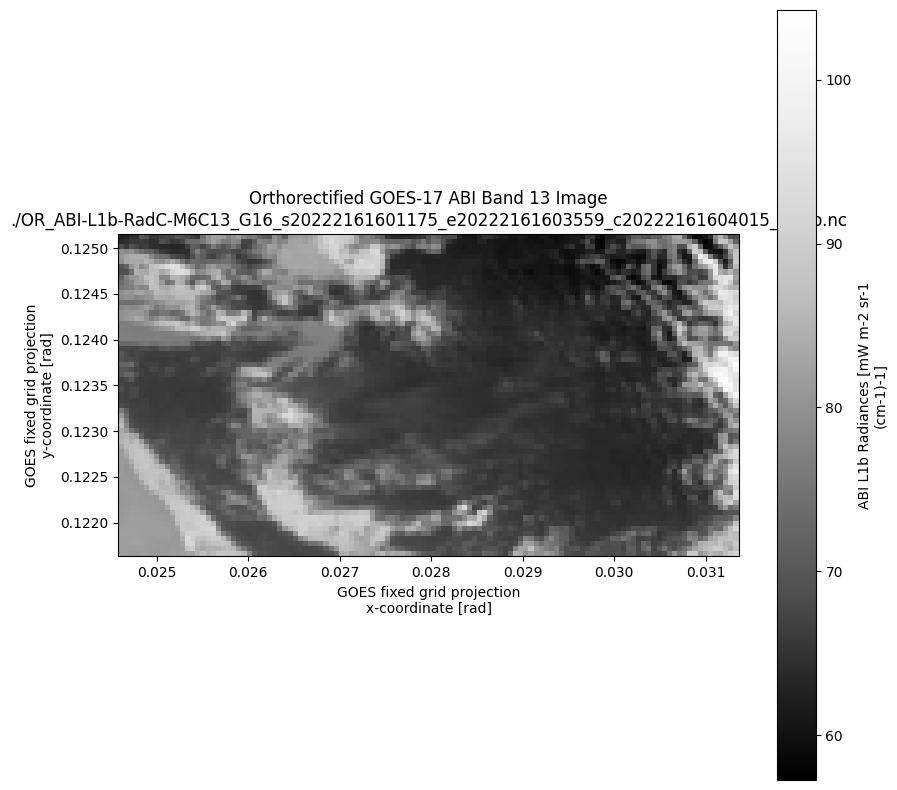

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_aspect(1)
ds.Rad.plot(ax=ax, cmap="Greys_r")
ax.set_title("Orthorectified GOES-17 ABI Band 13 Image\n{}".format(new_goes_filename));